In [1]:
import tensorflow as tf
from scipy.io import loadmat

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, BatchNormalization, Dropout, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


In this project, we will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). It is an  image dataset of over 600,000 digit images in all, and is more difficult to train than the MNIST dataset. SVHN is obtained from house numbers in Google Street View images. For more information, see the following paper:

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.


In [3]:
# Load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

train_data = train['X']
train_targets = train['y']
print('train data: ', train_data.shape)
print('train target: ', train_targets.shape)

test_data = test['X']
test_targets = test['y']
print('test data: ', test_data.shape)
print('test target: ', test_targets.shape, '\n')


# the first dimension in data should be the number of samples

def samples_to_first_dim(array):
    
    new_array = np.moveaxis(array, -1, 0)
    
    return new_array

train_data = samples_to_first_dim(train_data)
test_data = samples_to_first_dim(test_data)

print("after bringing the number of samples to the first dimension:\n")
print('train data: ', train_data.shape)
print('test data: ', test_data.shape,'\n')

# scale the data between  0 and 1

train_data = train_data/255.
test_data = test_data/255.



train data:  (32, 32, 3, 73257)
train target:  (73257, 1)
test data:  (32, 32, 3, 26032)
test target:  (26032, 1) 

after bringing the number of samples to the first dimension:

train data:  (73257, 32, 32, 3)
test data:  (26032, 32, 32, 3) 

min target: 0
max target: 9


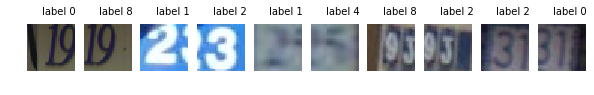

In [4]:
# randomly select and plot some data images

num_random_samples = 10
random_sample_index = np.random.choice(train_data.shape[0], num_random_samples, replace = False)

fig, ax = plt.subplots(1, num_random_samples, figsize=(num_random_samples,1))
fig.subplots_adjust(wspace=+.2)

for i in range(num_random_samples):
    ax[i].set_axis_off()
    ax[i].imshow(train_data[i])
    ax[i].text(10., -6.5, f"label {train_targets[i][0]}")
    #print("label: ", train_targets[i])
    


In [5]:
train_data = np.mean(train_data, axis = -1, keepdims = True)
print("gray train data: ", train_data.shape)

test_data = np.mean(test_data, axis = -1, keepdims = True)
print("gray test data: ", test_data.shape)


gray train data:  (73257, 32, 32, 1)
gray test data:  (26032, 32, 32, 1)


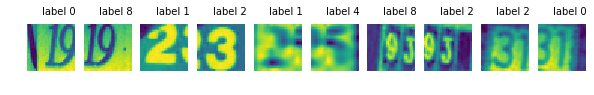

In [6]:
num_random_samples = 10
random_sample_index = np.random.choice(train_data.shape[0], num_random_samples, replace = False)

fig, ax = plt.subplots(1, num_random_samples, figsize=(num_random_samples,1))
fig.subplots_adjust(wspace=+.2)

for i in range(num_random_samples):
    ax[i].set_axis_off()
    ax[i].imshow(np.squeeze(train_data[i]))
    ax[i].text(10., -6.5, f"label {train_targets[i][0]}")

    
# scale the target values to be between 0 and 9

train_targets -= 1
test_targets  -= 1

print( f'min target: {np.min(train_targets)}')
print( f'max target: {np.max(train_targets)}')

In [7]:
# build a MLP model

def get_MLP_model(units, input_shape):
    """
    This functions returns a multi-layer perceptron.
    """
    model = Sequential([
        Flatten(input_shape = input_shape, name = 'flatten'),
        Dense(units = units, activation = 'relu', name = 'dense_1'),
        Dense(units = units//2, activation = 'relu', name = 'dense_2'),
        Dense(units = units//2, activation = 'relu', name = 'dense_3'),
        Dense(units = 10, activation = 'softmax')
    ])
    
    return model
    
    

In [8]:
MLP_model = get_MLP_model(64, train_data[0].shape)
MLP_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                65600     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense (Dense)                (None, 10)                330       
Total params: 69,066
Trainable params: 69,066
Non-trainable params: 0
_________________________________________________________________


In [9]:
MLP_model.compile(optimizer = 'adam',
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])

In [10]:
def get_best_weights():
    
    checkpoint_path = "model_checkpoints/best_checkpoint"
    
    best_checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                                     save_weights_only = True,
                                     monitor = 'val_loss',
                                     save_best_only = True)
    
    return best_checkpoint

def get_reduce_lr(rate, patience):
    
    reduce_learning_rate = ReduceLROnPlateau(monitor = 'accuracy', 
                                             factor = rate, patience = patience,
                                             min_delta = 0.03,
                                             verbose = 1)
    
    return reduce_learning_rate

In [11]:
reduce_lr = get_reduce_lr(0.5, 4)
best_checkpoint = get_best_weights()

In [12]:
history = MLP_model.fit(train_data, train_targets, 
                        epochs = 30, batch_size = 128,
                        callbacks = [reduce_lr, best_checkpoint],
                        validation_split = 0.15)

Train on 62268 samples, validate on 10989 samples
Epoch 1/30
62268/62268 [==============================] - 14s 228us/sample - loss: 2.1946 - accuracy: 0.2059 - val_loss: 2.0329 - val_accuracy: 0.3018
Epoch 2/30
62268/62268 [==============================] - 12s 194us/sample - loss: 1.8638 - accuracy: 0.3490 - val_loss: 1.7361 - val_accuracy: 0.4049
Epoch 3/30
62268/62268 [==============================] - 11s 181us/sample - loss: 1.6096 - accuracy: 0.4433 - val_loss: 1.5384 - val_accuracy: 0.4746
Epoch 4/30
62268/62268 [==============================] - 11s 185us/sample - loss: 1.4661 - accuracy: 0.4966 - val_loss: 1.4230 - val_accuracy: 0.5215
Epoch 5/30
62268/62268 [==============================] - 12s 185us/sample - loss: 1.3776 - accuracy: 0.5415 - val_loss: 1.3323 - val_accuracy: 0.5698
Epoch 6/30
62268/62268 [==============================] - 12s 188us/sample - loss: 1.3033 - accuracy: 0.5736 - val_loss: 1.2773 - val_accuracy: 0.5868
Epoch 7/30
62268/62268 [====================

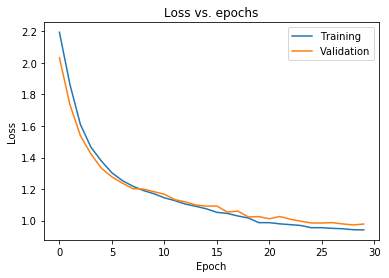

In [13]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

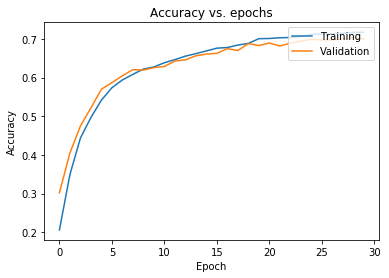

In [14]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [27]:
test_loss, test_acc = MLP_model.evaluate(test_data, test_targets, verbose = 0)
print('Test accuracy: {acc:0.3f}'.format(acc=test_acc))
print('Test loss: {loss:0.3f}'.format(loss=test_loss))

Test accuracy: 0.671
Test loss: 1.104


In [16]:
# build a CNN model

def get_CNN_model(input_shape, units, dropout_rate):
    
    model = Sequential([
        Conv2D(filters = 16, kernel_size = (3,3), padding = 'SAME',
              input_shape = input_shape, activation = 'relu', name = 'conv_1'),
        Conv2D(filters = 8, kernel_size = (3,3), padding = 'SAME',
              activation = 'relu', name = 'conv_2'),
        BatchNormalization(),
   #     Conv2D(filters = 8, kernel_size = (3,3), padding = 'SAME',
   #          activation = 'relu', name = 'conv_3'),
        MaxPooling2D(pool_size = (4,4), name = 'pool_1'),
        Flatten(name = 'flatten'),
        Dropout(dropout_rate),
        Dense(units = units, activation = 'relu', name = 'dense_1'),
        Dense(units = 10, activation = 'softmax', name = 'dense_2')
    ])
    
    return model

In [17]:
CNN_model = get_CNN_model(train_data[0].shape, 16, 0.3)
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 8)         1160      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 8)         32        
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 8, 8, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)               

In [18]:
CNN_model.compile(optimizer = 'adam',
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])

In [19]:
def get_best_weights():
    
    checkpoint_path = "CNN_model_checkpoints/CNN_best_checkpoint"
    
    best_checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                                     save_weights_only = True,
                                     monitor = 'val_accuracy',
                                     save_best_only = True)
    
    return best_checkpoint

def get_reduce_lr(rate, patience):
    
    reduce_learning_rate = ReduceLROnPlateau(monitor = 'accuracy', 
                                             factor = rate, patience = patience,
                                             min_delta = 0.03,
                                             verbose = 1)
    
    return reduce_learning_rate

In [20]:
reduce_lr_CNN = get_reduce_lr(0.5, 4)
best_checkpoint_CNN = get_best_weights()

In [21]:
history = CNN_model.fit(train_data, train_targets, 
                        epochs = 10, batch_size = 256,
                        callbacks = [reduce_lr_CNN, best_checkpoint_CNN],
                        validation_split = 0.15)

Train on 62268 samples, validate on 10989 samples
Epoch 1/10
62268/62268 [==============================] - 327s 5ms/sample - loss: 2.0555 - accuracy: 0.2571 - val_loss: 2.0534 - val_accuracy: 0.3531
Epoch 2/10
62268/62268 [==============================] - 329s 5ms/sample - loss: 1.3508 - accuracy: 0.5534 - val_loss: 1.2494 - val_accuracy: 0.6486
Epoch 3/10
62268/62268 [==============================] - 332s 5ms/sample - loss: 0.9854 - accuracy: 0.6845 - val_loss: 0.8486 - val_accuracy: 0.7550
Epoch 4/10
62268/62268 [==============================] - 331s 5ms/sample - loss: 0.8806 - accuracy: 0.7215 - val_loss: 0.7605 - val_accuracy: 0.7740
Epoch 5/10
62268/62268 [==============================] - 331s 5ms/sample - loss: 0.8331 - accuracy: 0.7369 - val_loss: 0.6886 - val_accuracy: 0.7988
Epoch 6/10
62268/62268 [==============================] - 329s 5ms/sample - loss: 0.7807 - accuracy: 0.7549 - val_loss: 0.6606 - val_accuracy: 0.8133
Epoch 7/10
62268/62268 [==========================

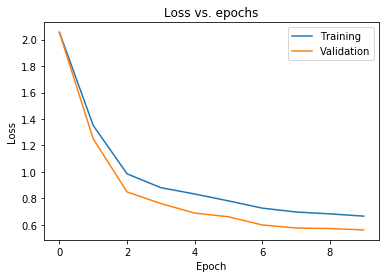

In [23]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

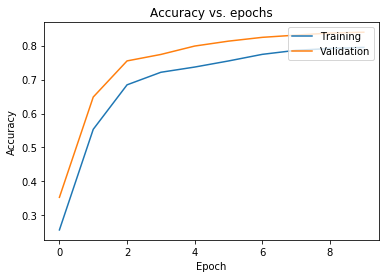

In [22]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [26]:
# verify that CNN model with fewer trainable parameters beat the MLP model

test_loss, test_acc = CNN_model.evaluate(test_data, test_targets, verbose = 0)
print('Test accuracy: {acc:0.3f}'.format(acc=test_acc))
print('Test loss: {loss:0.3f}'.format(loss=test_loss))

Test accuracy: 0.817
Test loss: 0.633


In [34]:
# load the best weights into models

new_MLP_model = get_MLP_model(64, train_data[0].shape)
new_MLP_model.load_weights("model_checkpoints/best_checkpoint")

new_CNN_model = get_CNN_model(train_data[0].shape, 16, 0.3)
new_CNN_model.load_weights("CNN_model_checkpoints/CNN_best_checkpoint")

Prediction output for the MLP model: 



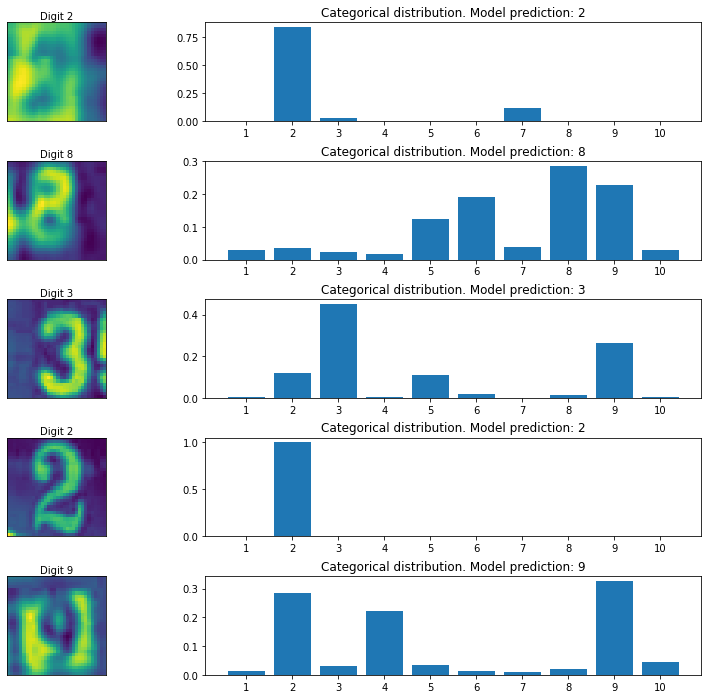

In [44]:
# plot the MLP model predictions

print("Prediction output for the MLP model: \n")

num_test_samples = test_data.shape[0]
num_random_draws = 5

random_inx = np.random.choice(num_test_samples, num_random_draws)
random_test_images = test_data[random_inx, ...]
random_test_labels = test_targets[random_inx, ...]

predictions = new_MLP_model.predict(random_test_images)

fig, axes = plt.subplots(num_random_draws, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label[0]+1}')
    axes[i, 1].bar(1+np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(1+np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)+1}")
    
plt.show()

Prediction output for the CNN model: 



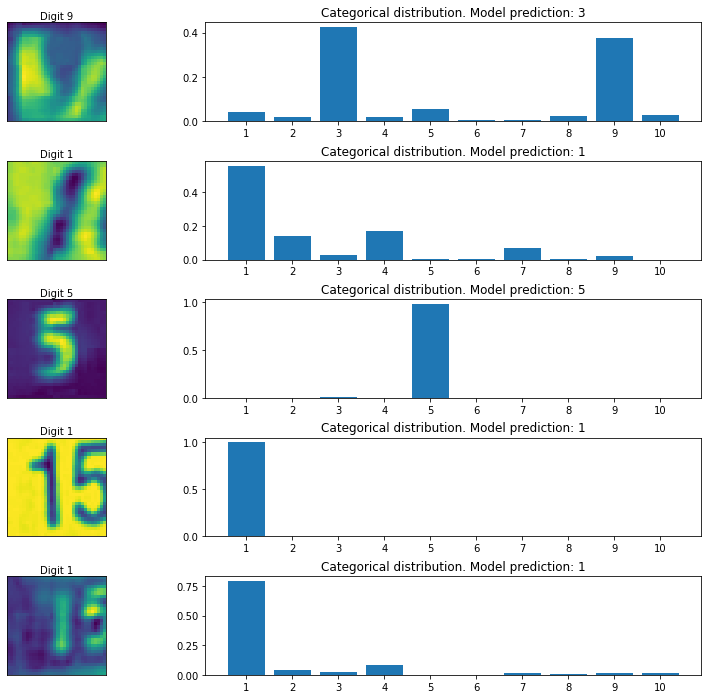

In [43]:
# Plot the CNN model predictions

print("Prediction output for the CNN model: \n")

num_test_samples = test_data.shape[0]
num_random_draws = 5

random_inx = np.random.choice(num_test_samples, num_random_draws)
random_test_images = test_data[random_inx, ...]
random_test_labels = test_targets[random_inx, ...]

predictions = new_CNN_model.predict(random_test_images)

fig, axes = plt.subplots(num_random_draws, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label[0]+1}')
    axes[i, 1].bar(1+np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(1+np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)+1}")
    
plt.show()